In [1]:
include("../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots, UnicodePlots
using OrdinaryDiffEq
const ODE = OrdinaryDiffEq

OrdinaryDiffEq

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [16]:
# Parameters
grid_resolution        = 100
quadrature_order       = 2
ϵ                      = 0.1             # perturbation
selected_ev            = 1
t_initial              = minimum(Time)
t_end                  = t_initial+80     # parameter value corresponding to ϵ=0 (t_max is 90)
wind_scale             = 1e-5
wind_center            = 30;
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5()

BS5(true)

In [17]:
lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
wind_v = zero(VT); #no northward component of wind
wind = interpolateVF(Lon, Lat, Time, wind_u, wind_v);

In [6]:
# it would be much easier to write this with interp_rhs and p=UV .+ param.*wind, but that has the wrong type
interp_rhs_scaled = ODE.ODEFunction{false}((u,p,t) -> p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t))
function T(x,param)
    flow(interp_rhs_scaled, x, [t_initial, t_end]; 
        p=(UV, wind, param), tolerance=solver_tolerance, solver=solver)[end]
end

T (generic function with 1 method)

In [7]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
ctx, _ = regularTriangularGrid((grid_resolution, Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [8]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
# assemble K
DT₀(x) = linearized_transfer_function_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata)
nothing

 37.102961 seconds (56.07 M allocations: 3.131 GiB, 3.65% gc time)


In [10]:
DTϵ(x) = linearized_transfer_function_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
@time Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
nothing

 25.005070 seconds (17.44 M allocations: 852.624 MiB, 1.02% gc time)


In [11]:
DTminusϵ(x) = linearized_transfer_function_autodiff(y -> T(y,-ϵ) , x)
Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
@time Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ, bdata=bdata)
nothing

 23.769104 seconds (17.27 M allocations: 842.918 MiB, 1.04% gc time)


In [12]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor_autodiff(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata)
nothing

207.637596 seconds (1.49 G allocations: 179.235 GiB, 10.00% gc time)


In [13]:
@time λs, us = eigs(K, M, which=:SM)
λϵs, uϵs = eigs(Kϵ, M, which=:SM)
λminusϵs, uminusϵs = eigs(Kminusϵ, M, which=:SM);

  3.199718 seconds (9.52 M allocations: 533.583 MiB, 5.06% gc time)


In [14]:
u₀ = us[:,selected_ev]
λ₀ = λs[selected_ev]
uϵ = uϵs[:,selected_ev]
λϵ = λϵs[selected_ev]
uminusϵ = uminusϵs[:,selected_ev]
λminusϵ = λminusϵs[selected_ev]

# L2 normalization
u₀ = u₀ ./ (u₀'*M*u₀)       
uϵ = uϵ ./ (uϵ'*M*uϵ)
uminusϵ = uminusϵ ./ (uminusϵ'*M*uminusϵ);  

In [15]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.686163 seconds (2.43 M allocations: 128.322 MiB, 4.19% gc time)


11.130410904704792

In [16]:
λ₀

-14.174206919280044

In [17]:
λϵ

-14.313814031171477

In [18]:
λminusϵ

-14.066673584846129

In [19]:
(λϵ .- λminusϵ) ./ (2*ϵ)

-1.2357022316267408

In [20]:
λ_dot

11.130410904704792

In [21]:
color = :balance;

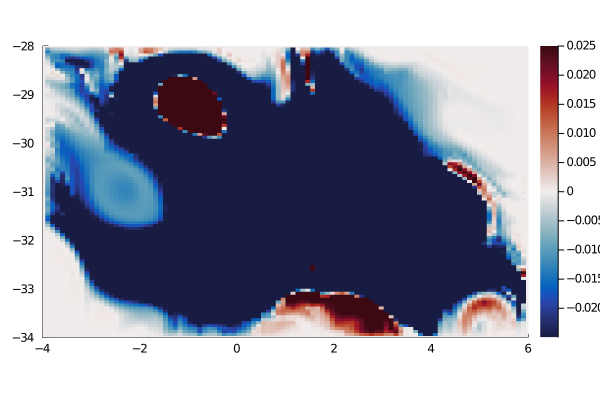

In [22]:
plot_u(ctx, u_dot,
        grid_resolution, grid_resolution, bdata=bdata, 
        colorbar=:left, color=color,clims=(-0.025,0.025))

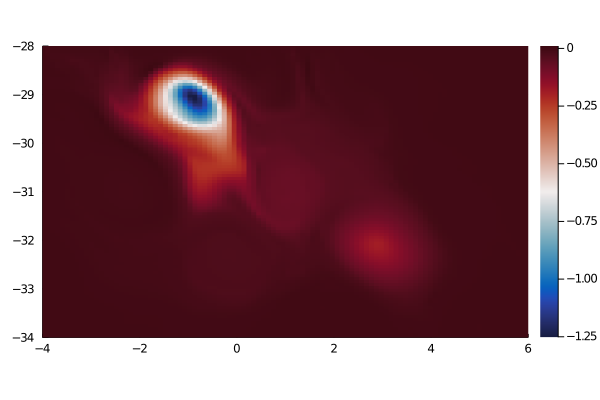

In [23]:
plot_u(ctx, u₀,
        grid_resolution, grid_resolution, bdata=bdata, 
        colorbar=:left, color=color)

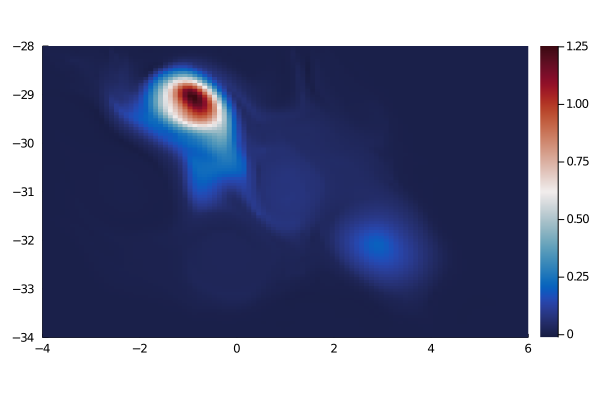

In [24]:
plot_u(ctx, uϵ,
        grid_resolution, grid_resolution, bdata=bdata, 
        colorbar=:left, color=color)

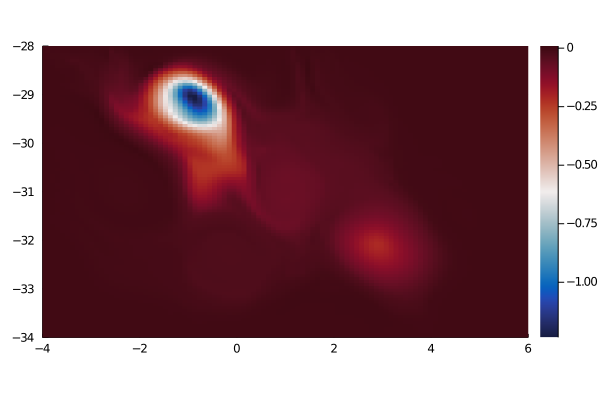

In [25]:
plot_u(ctx, uminusϵ,
        grid_resolution, grid_resolution, bdata=bdata, 
        colorbar=:left, color=color)

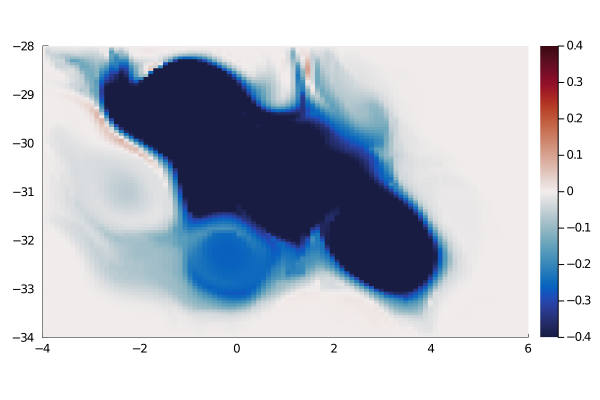

In [26]:
plot_u(ctx, (-uϵ - -uminusϵ) ./ (2*ϵ),
        grid_resolution, grid_resolution, bdata=bdata, 
        colorbar=:left, color=color, clims=(-0.4,0.4))

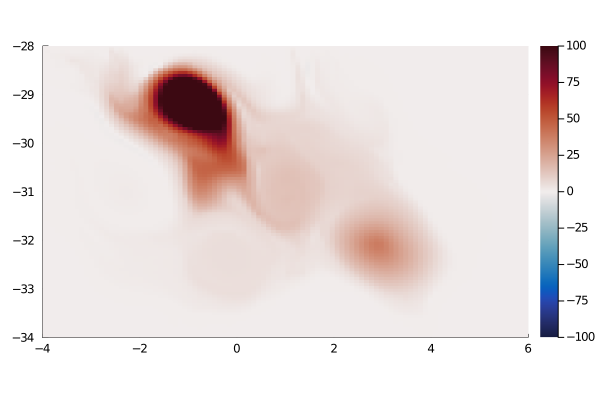

In [27]:
plot_u(ctx, (-uϵ + -uminusϵ .- (2*u₀)) ./ (ϵ.*ϵ),
        grid_resolution, grid_resolution, bdata=bdata, 
        colorbar=:left, color=color,clims=(-100,100))

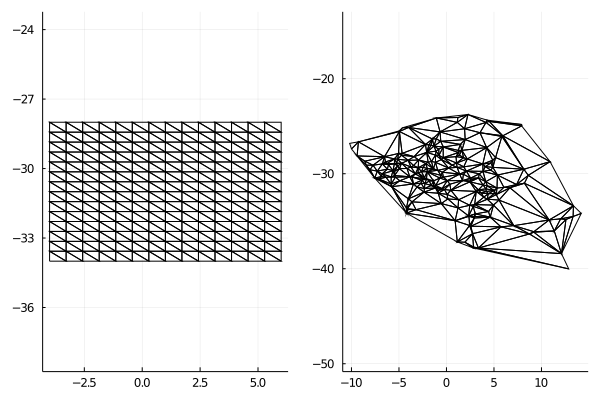

In [28]:
ctx_plot, _ = regularTriangularGrid((15, 15), LL, UR, quadrature_order = quadrature_order)
flow_map_t(j) = Vec{2}(T(ctx_plot.grid.nodes[j].x,0))
new_ctx_plot,_,_ = Main.CoherentStructures.adaptiveTOFutureGrid(ctx_plot,flow_map_t,flow_map_mode=1)

original_grid = Main.CoherentStructures.plot_grid(ctx_plot)
adapted_grid = Main.CoherentStructures.plot_grid(new_ctx_plot)
Plots.plot(original_grid,adapted_grid,fmt=:png)

In [31]:
new_ctx_plot.grid.cells

428-element Array{JuAFEM.Cell{2,3,3},1}:
 JuAFEM.Cell{2,3,3}((59, 26, 28))
 JuAFEM.Cell{2,3,3}((79, 107, 182))
 JuAFEM.Cell{2,3,3}((87, 201, 187))
 JuAFEM.Cell{2,3,3}((43, 18, 74))
 JuAFEM.Cell{2,3,3}((190, 218, 142))
 JuAFEM.Cell{2,3,3}((118, 12, 205))
 JuAFEM.Cell{2,3,3}((67, 31, 137))
 JuAFEM.Cell{2,3,3}((25, 27, 18))
 JuAFEM.Cell{2,3,3}((171, 170, 185))
 JuAFEM.Cell{2,3,3}((204, 154, 219))
 JuAFEM.Cell{2,3,3}((198, 140, 113))
 JuAFEM.Cell{2,3,3}((126, 198, 156))
 JuAFEM.Cell{2,3,3}((125, 101, 203))
 ⋮
 JuAFEM.Cell{2,3,3}((30, 74, 132))
 JuAFEM.Cell{2,3,3}((2, 132, 23))
 JuAFEM.Cell{2,3,3}((11, 15, 14))
 JuAFEM.Cell{2,3,3}((27, 14, 74))
 JuAFEM.Cell{2,3,3}((14, 38, 21))
 JuAFEM.Cell{2,3,3}((119, 21, 105))
 JuAFEM.Cell{2,3,3}((21, 38, 40))
 JuAFEM.Cell{2,3,3}((21, 40, 105))
 JuAFEM.Cell{2,3,3}((117, 89, 133))
 JuAFEM.Cell{2,3,3}((117, 45, 22))
 JuAFEM.Cell{2,3,3}((38, 15, 45))
 JuAFEM.Cell{2,3,3}((15, 28, 29))

In [46]:
new_ctx_plot.grid.nodes[1]

JuAFEM.Node{2,Float64}([-4.037056996171118, -33.769123743920666])

In [45]:
writedlm("D:/cells.csv", [cell.nodes for cell in new_ctx_plot.grid.cells], ",")